In [79]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [80]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [81]:
# Limiting the GPU Memory Consumption Growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Removing dodgy images (images with invalid extension etc)

In [82]:
import cv2
import imghdr

In [83]:
data_dir = '/kaggle/input/dataset-containing-happy-and-sad-images/data'

In [84]:
os.listdir(data_dir)

['sad', 'happy']

In [85]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [86]:
# looping through happy and sad subfolders
for image_class in os.listdir(data_dir):
    # looping through every single image in each subfolder
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # opens up an image
            img = cv2.imread(image_path)
            
            # determines the type of an image
            tip = imghdr.what(image_path)
            
            # removes images which don't match the extensions in the list
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [87]:
import numpy as np

In [88]:
# pipeline creation
# creates a dataset with resized images, labelled, etc
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/dataset-containing-happy-and-sad-images/data')

Found 305 files belonging to 2 classes.


In [89]:
# iterates over all images in a more flexible way using batches
data_iterator = data.as_numpy_iterator()

In [90]:
batch = data_iterator.next()

In [91]:
# batch size = 32 that's why it's 32, automatically reshaped earlier
batch[0].shape

(32, 256, 256, 3)

In [92]:
# first part of the batch is the images as numpy arrays
# second part of the batch is the labels of the images
len(batch)

2

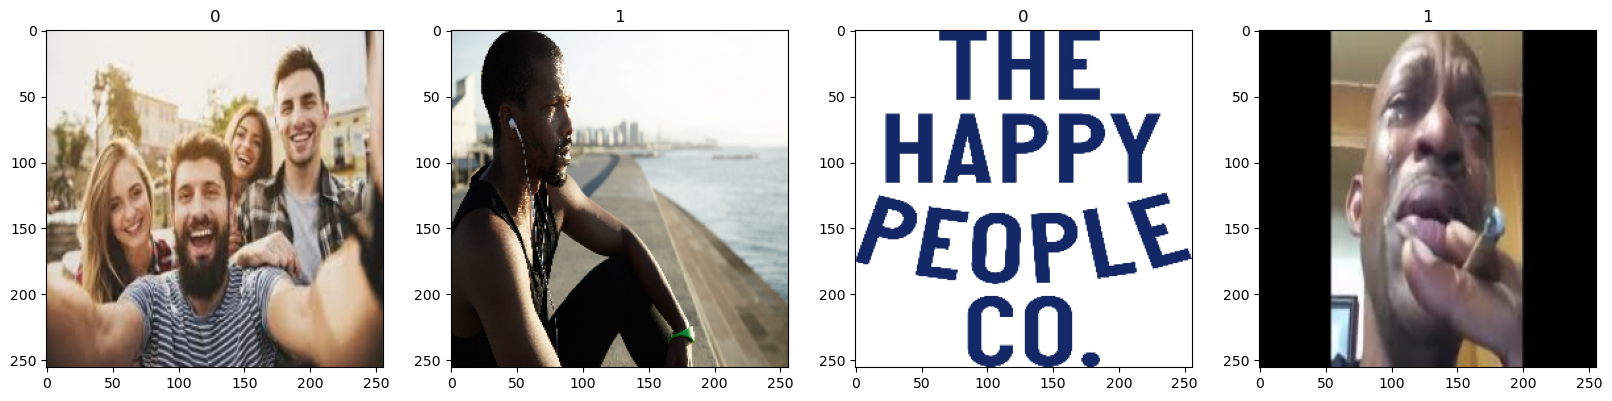

In [93]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
# display only the first four images in batch[0], which contains images, not labels
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    
    # batch[1] contains the labels
    ax[idx].title.set_text(batch[1][idx])

## 1 -> Sad People
## 0 -> Happy People

# Pre-Processing

In [94]:
# x->images, y->labels
# scaling the images from range 0-255 to a range 0-1

data = data.map(lambda x,y: (x/255, y))

# Train-Validation-Test Split

In [95]:
len(data)

10

In [96]:
# validation is used during training to tune the model better
# essentially a test set within the training itself

train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1) + 1

In [97]:
# skip the bacthes already allocated training, and use the next few bacthes for validation
# and use the whatever is left to test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).take(test_size)

# Building the CNN Model

In [98]:
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

In [99]:
model = Sequential()

In [100]:
# 16 filters, filter size of 3x3, stride of 1, relu -> 0 to infinity
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# dense layers are the fully connected layers of the network
model.add(Dense(256, activation='relu'))

#sigmoid -> 0 to 1
model.add(Dense(1, activation='sigmoid'))

In [101]:
# adam is an optimizer for updating learning rates during training
# binarycrossemtropy is a loss function to compare the predicted probabilities to the actual output which is 0 or 1 

model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [102]:
model.summary()

# 256 parameters in the final dense layer output + 1 for bias term, so 257 total parameters

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# Training the CNN Model

In [103]:
logdir = 'logs' 

In [104]:
# logs the training process of the model out into the logs folder
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [105]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
7/7 [==============================] - 8s 515ms/step - loss: 0.8441 - accuracy: 0.5268 - val_loss: 0.6498 - val_accuracy: 0.5309
Epoch 2/25
7/7 [==============================] - 6s 510ms/step - loss: 0.6478 - accuracy: 0.5223 - val_loss: 0.6399 - val_accuracy: 0.5309
Epoch 3/25
7/7 [==============================] - 8s 889ms/step - loss: 0.6141 - accuracy: 0.6295 - val_loss: 0.5946 - val_accuracy: 0.7037
Epoch 4/25
7/7 [==============================] - 8s 886ms/step - loss: 0.5556 - accuracy: 0.7411 - val_loss: 0.4700 - val_accuracy: 0.7531
Epoch 5/25
7/7 [==============================] - 6s 484ms/step - loss: 0.4059 - accuracy: 0.8259 - val_loss: 0.2904 - val_accuracy: 0.8889
Epoch 6/25
7/7 [==============================] - 8s 887ms/step - loss: 0.3214 - accuracy: 0.8661 - val_loss: 0.3760 - val_accuracy: 0.8395
Epoch 7/25
7/7 [==============================] - 8s 887ms/step - loss: 0.3095 - accuracy: 0.8571 - val_loss: 0.2162 - val_accuracy: 0.9630
Epoch 8/25
7/7 [====

In [106]:
hist.history

{'loss': [0.8441447615623474,
  0.647830605506897,
  0.6141027212142944,
  0.555591344833374,
  0.4058954417705536,
  0.3214447796344757,
  0.30945220589637756,
  0.23283028602600098,
  0.24962162971496582,
  0.14837999641895294,
  0.12618227303028107,
  0.1123509481549263,
  0.06834768503904343,
  0.058264460414648056,
  0.05060350149869919,
  0.030008967965841293,
  0.025050843134522438,
  0.030256109312176704,
  0.021420521661639214,
  0.008456265553832054,
  0.012290040962398052,
  0.012628121301531792,
  0.024092670530080795,
  0.014188980683684349,
  0.014553606510162354],
 'accuracy': [0.5267857313156128,
  0.5223214030265808,
  0.6294642686843872,
  0.7410714030265808,
  0.8258928656578064,
  0.8660714030265808,
  0.8571428656578064,
  0.9285714030265808,
  0.8928571343421936,
  0.9732142686843872,
  0.9508928656578064,
  0.9598214030265808,
  0.9910714030265808,
  0.9866071343421936,
  0.9866071343421936,
  0.9910714030265808,
  0.9910714030265808,
  0.9866071343421936,
  0.99

# Plotting the Performance

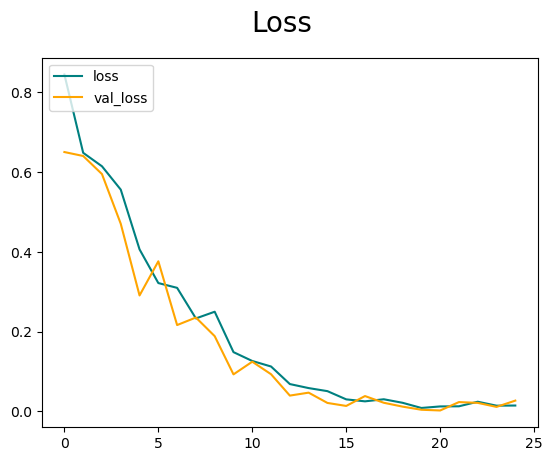

In [107]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Performance Evaluation

In [108]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [109]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [110]:
for batch in test.as_numpy_iterator():
    
    # X-> images, y->true value
    X, y = batch
    
    # yhat -> predicted value
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 31ms/step


In [111]:
print(f'Precision:{pre.result().numpy()}\nRecall:{re.result().numpy()}\nAccuracy:{acc.result().numpy()}')

Precision:1.0
Recall:1.0
Accuracy:1.0


# Testing

In [112]:
import cv2

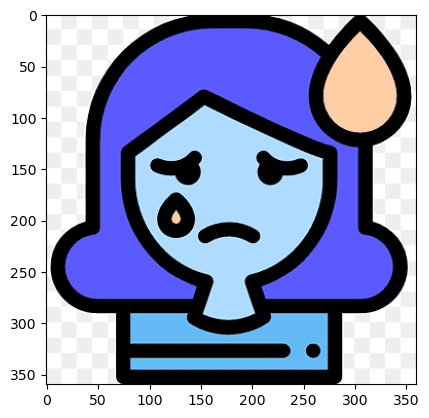

In [113]:
# RGB is internally getting printed as a BGR image

img = cv2.imread('/kaggle/input/image-of-a-sad-person/png-transparent-computer-icons-sad-person-computer-program-data-hypnosis-thumbnail.png')
plt.imshow(img)
plt.show()

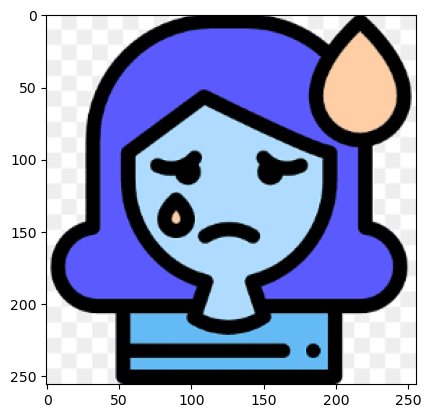

In [114]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [115]:
# increasing the number of dimensions of the test image
# because the model is expecting a batch of images, not just one
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 78ms/step


In [116]:
yhat

array([[0.04392963]], dtype=float32)

# 1 was sad so it's predicting correctly

In [117]:
if yhat > 0.5:
    print(f'Sad :(')
else:
    print(f'Happy :)')

Happy :)


# Saving the Model

In [125]:
from tensorflow.keras.models import load_model

In [131]:
model.save(os.path.join('models', 'happysadclassifier.h5'))

In [132]:
new_model = load_model(os.path.join('models', 'happysadclassifier.h5'))

In [133]:
new_model